In [1]:
import os
import numpy as np
import pandas as pd
import random
import torch
from torch import nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoderLayer, TransformerDecoder
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, lti, dlti, dstep
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import math
import scipy.integrate
import random
import autograd.numpy as np
from autograd import grad, jacobian

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=201):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class KalmanFormer(nn.Module):
    def __init__(self, f, h, m, n, hidden_dim=64, num_heads=2, num_layers=2, dropout=0.1):
        super(KalmanFormer, self).__init__()

        self.f = f  
        self.h = h  
        self.m = m  
        self.n = n 

        feature_dim_enc = 2 * n 
        feature_dim_dec = 2 * m  
  
        self.encoder_embedding = nn.Linear(feature_dim_enc, hidden_dim)
        self.decoder_embedding = nn.Linear(feature_dim_dec, hidden_dim)

  
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.pos_decoder = PositionalEncoding(hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads,
            dim_feedforward=64, 
            dropout=dropout, layer_norm_eps=1e-05, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

      
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim, nhead=num_heads,
            dim_feedforward=64,
            dropout=dropout, layer_norm_eps=1e-05, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

      
        self.kalman_gain = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, m * n)  
        )


    def InitSequence(self, M1_0, T):
        self.T = T
        self.m1x_posterior = M1_0
        self.m1x_posterior_previous = self.m1x_posterior
        self.m1x_prior_previous = self.m1x_posterior
        self.y_previous = self.h(self.m1x_posterior)

    def step_prior(self):
        self.m1x_prior = self.f(self.m1x_posterior)
        self.m1y = self.h(self.m1x_prior)

    def compute_kalmanformer_inputs(self, x_post, x_post_prev, x_prior_prev, y_prior, y_previous, y):
       
        
        F1 = (y - y_previous).squeeze(-1)
        F2 = (y - y_prior).squeeze(-1)
        F3 = (x_post - x_post_prev).squeeze(-1)
        F4 = (x_post - x_prior_prev).squeeze(-1)

        F_encoder = torch.cat([F1, F2], dim=-1).unsqueeze(1)
        F_decoder = torch.cat([F3, F4], dim=-1).unsqueeze(1)

        return F_encoder, F_decoder

    def Kalman_step(self, y_t):
        self.step_prior()

        F_encoder, F_decoder = self.compute_kalmanformer_inputs(
            self.m1x_posterior, self.m1x_posterior_previous,
            self.m1x_prior_previous, self.m1y, self.y_previous,  y_t
        )

        enc = self.encoder_embedding(F_encoder)
        enc = self.pos_encoder(enc)
        memory = self.encoder(enc)

        dec = self.decoder_embedding(F_decoder)
        dec = self.pos_decoder(dec)
        decoded = self.decoder(dec, memory)

        kalman_gain = self.kalman_gain(decoded).squeeze(1) 
        kalman_gain = kalman_gain.view(-1, self.m, self.n)      
        
        kalman_gain = torch.clamp(kalman_gain, -1e3, 1e3)

        dy = y_t - self.m1y
        INOV = torch.bmm(kalman_gain, dy)
        INOV = torch.nan_to_num(INOV, nan=0.0, posinf=1e6, neginf=-1e6)

        

        self.m1x_posterior_previous = self.m1x_posterior
        self.m1x_posterior = self.m1x_prior + INOV
        self.m1x_prior_previous = self.m1x_prior
        self.y_previous = y_t

        return self.m1x_posterior

    def forward(self, y_sequence):
        batch_size, seq_len, _, _ = y_sequence.shape
        preds = []
        for t in range(seq_len):
            y_t = y_sequence[:, t, :, :] 
            x_hat = self.Kalman_step(y_t)
            preds.append(x_hat.unsqueeze(1))

        return torch.cat(preds, dim=1)

In [3]:
#  Old data

# def generate_lorenz_data(seq_length=200, num_records=50, dt=0.01):
#     dim_y = 1
#     dim_x = 3
#     end_t = seq_length * dt

#     X_data_array = np.empty((num_records, seq_length, dim_x))
#     Y_data_array = np.empty((num_records, seq_length, dim_y))

#     def f(x):
#         s, r, b = 10.0, 28.0, 8.0 / 3.0
#         x1, x2, x3 = x
#         dx1 = -s * x1 + s * x2
#         dx2 = r * x1 - x2 - x1 * x3
#         dx3 = x1 * x2 - b * x3
#         return np.array([dx1, dx2, dx3])

#     def step_forward(x):
#         return x + dt * f(x)

#     P = 0.0001 * np.eye(dim_x)
#     Q = 0.01 * np.eye(dim_x)
#     R = [0.01]
#     G = np.eye(dim_x)
#     H = np.array([[1, 1, 0]])
#     mu_mn = np.zeros(dim_y)

#     for i in range(num_records):
#         mu_x0 = np.random.uniform(-2, 2, size=3)
#         x = np.random.multivariate_normal(mu_x0, P)
#         X_data_array[i, 0, :] = x
#         Y_data_array[i, 0, :] = np.matmul(x, H.T) + np.random.normal(mu_mn, R)

#         for j in range(1, seq_length):
#             x = step_forward(x)
#             x = x + G @ np.random.multivariate_normal(np.zeros(dim_x), Q)
#             X_data_array[i, j, :] = x
#             Y_data_array[i, j, :] = np.matmul(x, H.T) + np.random.normal(mu_mn, R)

#     return X_data_array, Y_data_array, H

# print(generate_lorenz_data(seq_length=200, num_records=50, dt=0.01)[0].shape)


#  New data from paper
def generate_lorenz_data_torch(seq_length=200, num_records=50, dt=0.01):
    dim_x = 3
    dim_y = 1
    C = torch.tensor([[-10, 10, 0],
                      [28, -1, 0],
                      [0, 0, -8/3]], dtype=torch.float32)

    H = torch.tensor([[1.0, 1.0, 0.0]], dtype=torch.float32).reshape(1, dim_y, dim_x)


    def f(x):
        BX = torch.zeros(x.shape[0], dim_x, dim_x)
        BX[:, 1, 0] = -x[:, 2, 0]
        BX[:, 2, 0] = x[:, 1, 0]
        A = BX + C
        F = torch.eye(dim_x).unsqueeze(0).repeat(x.shape[0], 1, 1)
        for j in range(1, 6): 
            F += torch.matrix_power(A * dt, j) / math.factorial(j)
        return torch.bmm(F, x)

    Q = 0.01 * torch.eye(dim_x)
    R = 0.01 * torch.eye(dim_y)

    X_data = torch.empty((num_records, seq_length, dim_x, 1))
    Y_data = torch.empty((num_records, seq_length, dim_y, 1))

    for i in range(num_records):
        x = torch.randn(dim_x, 1).uniform_(-2, 2)
        x += torch.randn_like(x) * 0.01
        
        x = x.unsqueeze(0)

        y = torch.bmm(H, x) + torch.randn(1, dim_y, 1) * torch.sqrt(R)

        X_data[i, 0] = x.squeeze(0)
        Y_data[i, 0] = y.squeeze(0)

        for t in range(1, seq_length):
            x = f(x)
            L = torch.linalg.cholesky(Q)
            x += torch.matmul(L, torch.randn_like(x))

           
            y = torch.bmm(H, x) + torch.randn(1, dim_y, 1) * math.sqrt(R[0, 0])


            X_data[i, t] = x.squeeze(0)
            Y_data[i, t] = y.squeeze(0)

    return X_data, Y_data, H



X_data, Y_data, H_tensor = generate_lorenz_data_torch(seq_length=200, num_records=50, dt=0.01)





In [4]:
def data_loaders(X_np, Y_np, batch_size, train_ratio, val_ratio):
   
  
    X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(-1)  
    Y = torch.tensor(Y_np, dtype=torch.float32).unsqueeze(-1)  

    dataset = TensorDataset(Y, X)

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_data = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_data = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_data, val_data, test_data



In [5]:
def train_kalmanformer(model, data_loader, optimizer, epochs):
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            y_seq, x_true = batch 
            _, T, n,_ = y_seq.shape
            
            m = x_true.shape[2]
            x0 = torch.zeros_like(x_true[:, 0, :, :])

            model.InitSequence(x0, T)
            preds = model(y_seq[:, 1:])  
            loss = F.mse_loss(preds, x_true[:, 1:, :, :]) 

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
#         if epoch%10 == 0:
        print(f"Epoch {epoch + 1}: Loss = {total_loss:.6f}")

In [6]:
# Old data

# def f(x):
#     s, r, b = 10.0, 28.0, 8.0 / 3.0
#     x1, x2, x3 = x[:, 0, 0], x[:, 1, 0], x[:, 2, 0]
#     dx1 = -s * x1 + s * x2
#     dx2 = r * x1 - x2 - x1 * x3
#     dx3 = x1 * x2 - b * x3
    
#     return torch.stack([dx1, dx2, dx3], dim=1).unsqueeze(-1)

# def step_forward(x, dt = 0.05):
#     return x + dt * f(x)

# def jacobian_f(state):
#     eps = 1e-6
#     n = len(state)
#     J = np.zeros((n, n))
#     f0 = f(state)
#     print(type(f0))
#     for i in range(n):
#         dx = np.zeros(n)
#         dx[i] = eps
#         f1 = step_forward(state + dx)
#         J[:, i] = (f1 - f0) / eps

#     return J

#  New data from paper
C = torch.tensor([[-10, 10,    0],
                  [ 28, -1,    0],
                  [  0,  0, -8/3]]).float()
m  = 3
J = 5
delta_t = 0.01
def f_jacob(x):
    BX = torch.zeros([x.shape[0], m, m], dtype=torch.float32, device=x.device)
    BX[:, 1, 0] = -x[:, 2, 0]
    BX[:, 2, 0] = x[:, 1, 0]
    
    A = BX + C.to(x.device)
    A = torch.clamp(A, -30.0, 30.0)  
    F = torch.eye(m, device=x.device).reshape(1, m, m).repeat(x.shape[0], 1, 1)
    for j in range(1, J+1):
        F_add = torch.matrix_power(A * delta_t, j) / math.factorial(j)
        F = F + F_add
    F = torch.clamp(F, -1e3, 1e3)  
    return torch.bmm(F, x)


H = torch.tensor(H_tensor, dtype=torch.float32)

def h(x):
    return torch.matmul(H_tensor.repeat(x.shape[0], 1, 1), x)  

dim_x = X_data.shape[2]
dim_y = Y_data.shape[2]

train_data, val_data, test_data = data_loaders(X_data.squeeze(-1), Y_data.squeeze(-1), batch_size=40, train_ratio=0.8, val_ratio=0.1)

model = KalmanFormer(f=f_jacob, h=h, m=dim_x, n=dim_y, hidden_dim=128, num_heads=2, num_layers=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

import time
start = time.time()
train_kalmanformer(model, train_data, optimizer, epochs=10)
end = time.time()
print("Training time:", end - start)


<ipython-input-6-d1cf9c1c2d71>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H = torch.tensor(H_tensor, dtype=torch.float32)
<ipython-input-4-15b39078f6d7>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(-1)
<ipython-input-4-15b39078f6d7>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_np, dtype=torch.float32).unsqueeze(-1)


Epoch 1: Loss = 5645.116699
Epoch 2: Loss = 2315.694580
Epoch 3: Loss = 1207.462769
Epoch 4: Loss = 731.050598
Epoch 5: Loss = 286.245789
Epoch 6: Loss = 102.525856
Epoch 7: Loss = 53.274231
Epoch 8: Loss = 19.861614
Epoch 9: Loss = 14.257562
Epoch 10: Loss = 6.845304
Training time: 83.94217300415039


In [11]:
def evaluate_kalmanformer_true_mse(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_seqs = 0

    for batch in data_loader:
        y_seq, x_true = batch  
        b, T, m, _ = x_true.shape
        x0 = torch.zeros_like(x_true[:, 0, :, :])  
#         x0 = x_true[:, 0, :, :]  
        model.InitSequence(x0, T)

        x_pred = model(y_seq[:, 1:])   
    

        x_gt = x_true[:, 1:, :, :]           
#         print(x_pred[0] - x_gt[0])
        loss = F.mse_loss(x_pred, x_gt)  
        total_loss += loss.item()
#         total_seqs += b  


    final_mse = total_loss 
    print(f"[MSE] = {final_mse:.6f}")
    return final_mse

In [12]:
evaluate_kalmanformer_true_mse(model, test_data)


[MSE] = 11.229850


11.229849815368652

In [17]:
def plot_pred_vs_true_simple(model, batch, title_prefix="Train"):
    model.eval()
    y_seq, x_true = batch
    x0 = torch.zeros_like(x_true[:, 0, :, :])  
#     x0 = x_true[:, 0, :, :]
    T = y_seq.shape[1]

    model.InitSequence(x0, T)
    
    with torch.no_grad():
        x_pred = model(y_seq[:, 1:]) 

    x_true = x_true[:, 1:, :, :]     

    idx = 1
    pred_np = x_pred[idx].cpu().numpy()  
    true_np = x_true[idx].cpu().numpy()  

    time = np.arange(pred_np.shape[0])
    for state in range(pred_np.shape[1]-1):
        plt.plot(time, true_np[:, state], label=f'True State {idx}')
        plt.plot(time, pred_np[:, state], '--', label=f'Pred State {idx}')

    plt.title(f'{title_prefix} Trajectory')
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


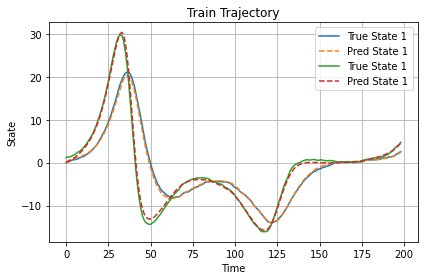

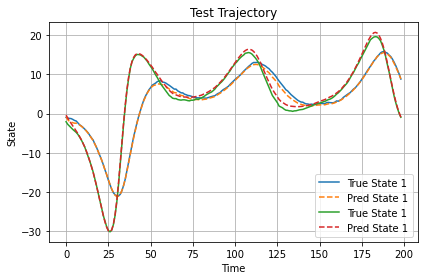

In [18]:

plot_pred_vs_true_simple(model, next(iter(train_data)), title_prefix="Train")
plot_pred_vs_true_simple(model, next(iter(test_data)), title_prefix="Test")